# Circulation Analysis

This notebook investigates the zonal average overturning circulation in the meridional/pressure plane. The idea is to see if it has the Hadley and Ferrel cell structure that the Earth does.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, lapse_moist
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, frierson_sw_optical_depth, frierson_atmospheric_heating
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v, radius_earth
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean
from isca_tools.papers.miyawaki_2022 import get_dmse_dt, get_dvmse_dy, get_r1
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
from scipy.interpolate import UnivariateSpline

2023-03-10 17:12:33,272 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


## Aquaplanet

In [33]:
exp_dir = 'tau_sweep/aquaplanet/'
var_keep = ['ucomp', 'vcomp', 'omega']      # only keep winds
tau_lw = 1
tau_lw_warm = 1.5
exp_names = [f"k={str(tau_lw).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
evap_param = []

# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    # Take zonal and time mean
    ds += [ds_use.sel(time=slice(use_time_start, np.inf)).mean(dim=['time', 'lon']).load()]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        evap_param += [namelist['surface_flux_nml']['land_evap_prefactor']]
    except KeyError:
        print(f'Experiment {i}: Evap param not specified so set to default value of 1')
        evap_param += [1]


Experiment 0: Evap param not specified so set to default value of 1
Experiment 1: Evap param not specified so set to default value of 1


Below we clearly see that we have a double ITCZ - an ITCZ in each hemisphere at pressures above $600hPa$ with descent at the equator.

In [34]:
n_p = ds[0].pfull.size
n_lat = ds[0].lat.size
stream = [np.zeros((n_p, n_lat)), np.zeros((n_p, n_lat))]
cos_lat = np.asarray(np.cos(np.deg2rad(ds[0].lat)))
for k in range(n_exp):
    for i in range(n_p):
        stream[k][i] = integrate.simpson(ds[k].vcomp[:i+1], ds[k].pfull[:i+1] * 100, axis=0)
        stream[k][i] = 2 * np.pi * radius_earth * cos_lat[np.newaxis] / g * stream[k][i]  # get into correct units of kg/s

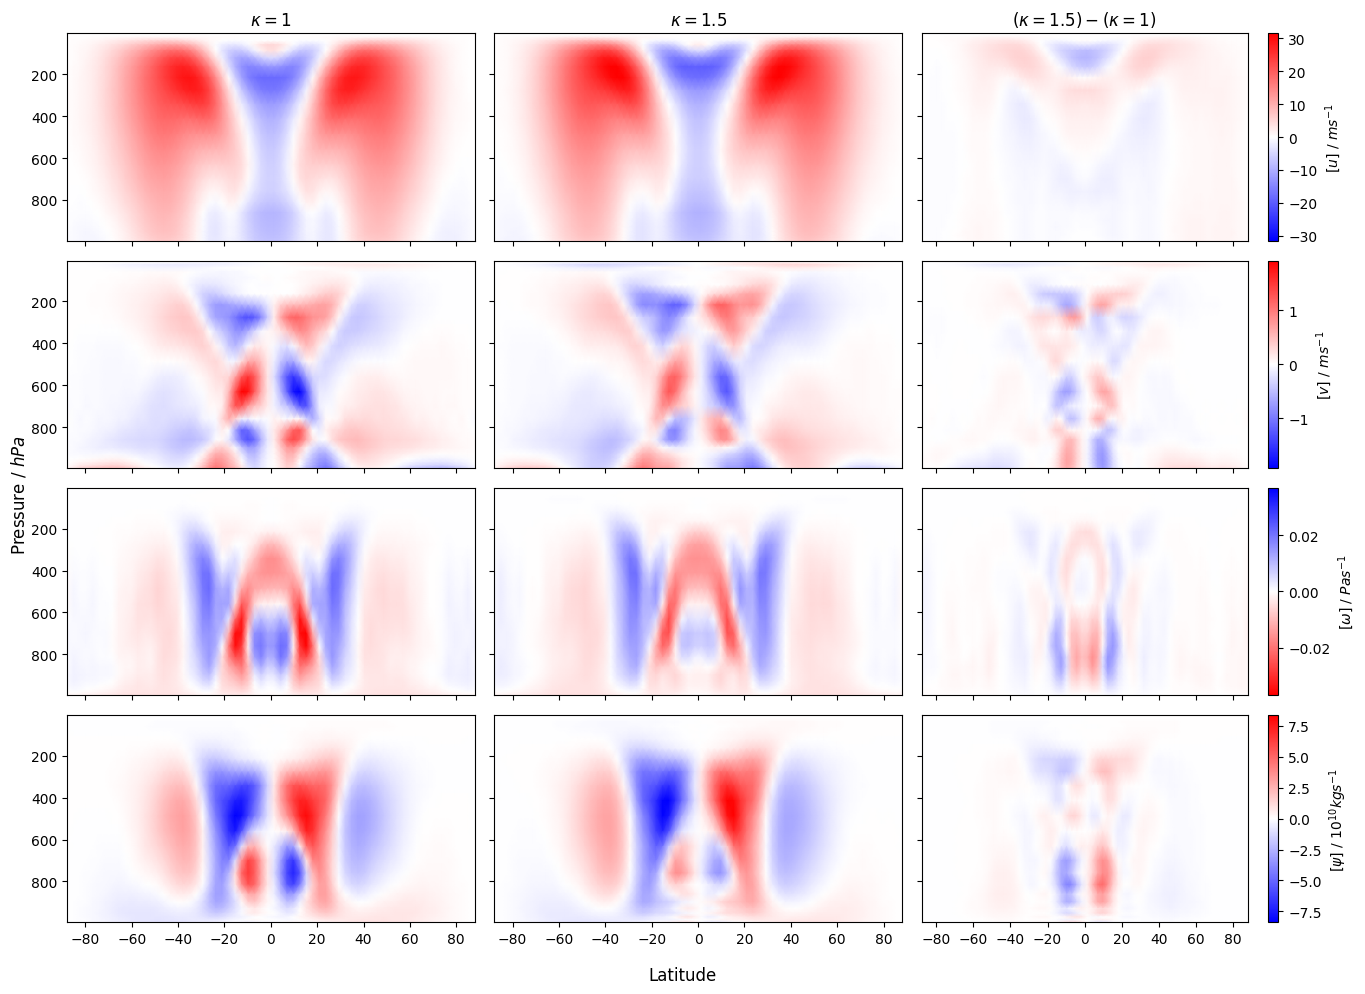

In [59]:
u_max = np.asarray([np.abs(ds[i].ucomp).max() for i in range(n_exp)]).max()
v_max = np.asarray([np.abs(ds[i].vcomp).max() for i in range(n_exp)]).max()
omega_max = np.asarray([np.abs(ds[i].omega).max() for i in range(n_exp)]).max()
stream_max = np.asarray([np.abs(stream[i]).max() for i in range(n_exp)]).max() /10**10
labels = ['$[u]$ / $ms^{-1}$', '$[v]$ / $ms^{-1}$', '$[\omega]$ / $Pas^{-1}$', '$[\psi]$ / $10^{10} kgs^{-1}$']
var_max = [u_max, v_max, omega_max, stream_max]
var_diff = [ds[1].get(var)-ds[0].get(var) for var in ['ucomp', 'vcomp', 'omega']]
var_diff += [(stream[1] - stream[0])/10**10]

fig, ax = plt.subplots(4,3, figsize=(14, 10), sharex=True, sharey=True)
for i in range(n_exp):
    for k, var  in enumerate([ds[i].ucomp, ds[i].vcomp, ds[i].omega, stream[i]/10**10]):
        if 'omega' in labels[k]:
            cmap = 'bwr_r'      # reverse cmap for pressure velocity
        else:
            cmap = 'bwr'
        im = ax[k, i].pcolormesh(ds[0].lat, ds[0].pfull, var, cmap=cmap, shading='gouraud',
                                 vmin=-var_max[k], vmax=var_max[k])
        if i == 0:
            im = ax[k, -1].pcolormesh(ds[0].lat, ds[0].pfull, var_diff[k], cmap=cmap, shading='gouraud',
                         vmin=-var_max[k], vmax=var_max[k])
            plt.colorbar(im, ax=ax[k, -1], label=labels[k])
ax[0, 0].invert_yaxis()
ax[0,0].set_title(f'$\kappa = {tau_lw[0]}$')
ax[0,1].set_title(f'$\kappa = {tau_lw[1]}$')
ax[0,2].set_title(f'$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$')
fig.supxlabel('Latitude')
fig.supylabel('Pressure / $hPa$')
plt.tight_layout();